In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, lasso_path

np.set_printoptions(precision=3, linewidth=np.inf)
np.random.seed(2023)

# 线性回归的压缩估计

上一部分介绍了线性回归模型的基本形式, 并在一个简单数据集上拟合了此线性模型, 发现它在训练集和测试集上的表现大致相当. 现在尝试一个更大的数据集: California房价数据集.

In [2]:
caX, cay = fetch_california_housing(return_X_y=True)
caX_train, cay_train = caX[:15000], cay[:15000]
caX_test, cay_test = caX[15000:], cay[15000:]

lr = LinearRegression().fit(caX_train, cay_train)
print('R2 of training set: {}'.format(lr.score(caX_train, cay_train)))
print('R2 of testing set: {}'.format(lr.score(caX_test, cay_test)))

R2 of training set: 0.5936388868438899
R2 of testing set: 0.5931322421964108


在特征数量小且数据近似线性的情况下, 简单线性回归也能发挥较好的效果; 但如果特征数量很大而样本数量不足, 或者数据不是线性的情况下, 简单线性回归就可能会引入较大的样本外误差. 当线性回归模型的样本外误差较大时, 可以使用压缩估计来估计线性回归模型的参数. 常用的压缩估计有以下三种: 岭回归, Lasso和Elastic Net, 它们以不同的方式限制了线性回归中模型系数的大小, 从而牺牲一部分样本内解释能力, 来换取更大的样本外解释能力.

具体而言, 三种压缩估计与简单线性回归一致, 对样本的预测仍然遵循

$$
\hat{y}_i=w_0+X_iw,
$$

不同的是它们的优化目标有所不同. 根据之前的讨论, 简单线性回归希望最小化残差平方和, 即损失函数为

$$
J(w,w_0)=\sum_{i=1}^{n}(y_i-(w_0+X_iw))^2=\|Xw-y\|^2
$$

而压缩估计将估计量的系数也添加到损失函数中[(1)](https://scikit-learn.org/stable/modules/linear_model.html), 从而改变损失函数最小时 $(w,w_0)$ 的取值:

$$
J_\text{Ridge} = \|Xw-y\|^2+\alpha\|w\|^2_2,
$$

$$
J_\text{Lasso} = \frac{1}{2n_\text{samples}}\|Xw-y\|^2+\alpha\|w\|_1,
$$

$$
J_\text{ElasticNet} = \frac{1}{2n_\text{samples}}\|Xw-y\|^2+\alpha\rho\|w\|_1+\frac{\alpha(1-\rho)}{2}\|w\|_2^2.
$$

这里 $\|w\|_2^2=\sum w_i^2$, $\|w\|_1=\sum |w_i|$. 也就是说, 三种不同的压缩估计选择了三种损失函数, 以得到不同的估计值偏离. 另外, 损失函数中出现的 $\alpha>0$ 和 $\rho\in[0,1]$ 都需要事先指定为某个常数, 在训练过程中不更新. 在sklearn中将这种量称为**参数**, 而统计学习中常称之为超参数, 这种名字上的差异注意即可, 我们均使用sklearn中的称呼.

下面根据实例分别介绍三种压缩估计.

## 岭回归

岭回归对回归系数 $w$ 施加了 $L_2$ 正则项, 即用参数平方和作为约束. 这样做的好处是损失函数仍是可微的, 能得到解析解, 不过这不在我们的讨论范围内.

sklearn使用`Ridge`创建一个岭回归实例, 不同于简单线性回归, 参数 $\alpha$ 需要在创建实例时就确认, 默认为 $1.0$. 另外, 岭回归有许多种求解方式, 可以通过`solver`指定, 并且每种求解方式还有个性化的参数, 这不是我们要讨论的重点, 如有兴趣可翻阅[[3]](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). 这里我们先创建一个岭回归模型, 并用训练数据拟合.

可以用`get_params`方法查看sklearn模型的参数列表, 它返回一个包含模型参数的字典. 下面的信息给出了此模型所拥有的参数, 我们不关心后面的参数含义, 只需要了解`alpha`参数代表上面损失函数中的惩罚系数即可.

In [3]:
ridge = Ridge(alpha=5.0).fit(caX_train, cay_train)
for key, value in ridge.get_params().items():
    print(f'{key}: {value}.')

alpha: 5.0.
copy_X: True.
fit_intercept: True.
max_iter: None.
normalize: deprecated.
positive: False.
random_state: None.
solver: auto.
tol: 0.001.


下面用 $R^2$ 评估岭回归在训练集和测试集上的解释能力. 注意, 任何压缩估计都不可能在训练集上有高过简单线性回归的 $R^2$, 这是其性质决定的.

````{margin}
```{note}
这里, 岭回归的表现没有简单线性回归好, 这是正常的, 因为简单线性回归没有表现出过拟合, 不需要使用压缩估计.
```
````

In [4]:
print('R2 of training set(ridge): {}'.format(ridge.score(caX_train, cay_train)))
print('R2 of testing set(ridge): {}'.format(ridge.score(caX_test, cay_test)))

R2 of training set(ridge): 0.5936376967588064
R2 of testing set(ridge): 0.5929825029783832


岭回归模型的关键在参数`alpha`, 但最优`alpha`值是事先不知道的. 常用的方法是拟定一系列`alpha`值, 选择其中表现最好的模型, 即使用网格搜索. 在事先不知道最优`alpha`的情况下, 一般根据量级设置不同`alpha`值. 除了用下面的方法进行人工搜索外, [`RidgeCV`类](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)也给出了自动搜索最优`alpha`值的方法, 它不仅比人工实现更方便, 还有更高的运行效率.

下图也说明了本例中, 不使用压缩估计会是更好的选择.

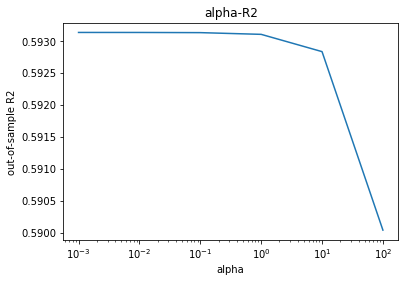

In [5]:
alphas = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
oosR2 = []

for alpha in alphas:
    temp_reg = Ridge(alpha=alpha).fit(caX_train, cay_train)
    oosR2.append(temp_reg.score(caX_test, cay_test))
    
plt.figure(1)
ax = plt.gca()
ax.plot(alphas, oosR2)
ax.set_xscale("log")
ax.set_xlabel('alpha')
ax.set_ylabel('out-of-sample R2')
ax.set_title('alpha-R2')
plt.show()

## LASSO回归

Lasso对回归系数施加了 $L_1$ 正则项, 这样虽然使得损失函数不可微, 但却使模型倾向于保留稀疏解, 相当于模型自动进行特征选择. sklearn用`Lasso`类创建实例, 其参数与`Ridge`类似. 同样地, 我们可以用搜索或者`LassoCV`来找到最佳超参数, 下面的结果表明依然不需要正则化.

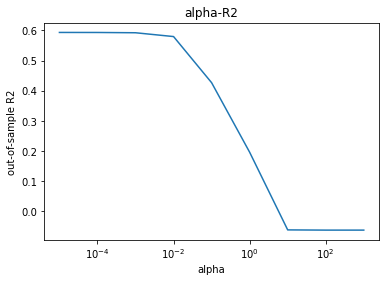

In [6]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
oosR2 = []

for alpha in alphas:
    temp_reg = Lasso(alpha=alpha).fit(caX_train, cay_train)
    oosR2.append(temp_reg.score(caX_test, cay_test))

plt.figure(1)
ax = plt.gca()
ax.plot(alphas, oosR2)
ax.set_xscale("log")
ax.set_xlabel('alpha')
ax.set_ylabel('out-of-sample R2')
ax.set_title('alpha-R2')
plt.show()

不过, Lasso的特征筛选能力在面临大量特征时很有用. 使用`lasso_path()`函数可以生成系数随着`alpha`变化的路径, 观察变量是如何被筛选的. 它除了接受待拟合的数据外, 还接收一系列`alpha`值, 可以通过以下参数传入系列`alpha`值.

- `eps`: 自动选择`alpha`值, 其中`eps = alpha_min / alpha_max`.
- `n_alphas`: 整数, 指定要尝试的`alpha`值的数量.
- `alphas`: 直接指定`alpha`值列表.

然后, `lasso_path`会返回

- `alphas`: 函数尝试的`alpha`值列表, 是形状为`(n_alphas,)`的数组.
- `coefs`: 每个`alpha`值对应的属性系数, 形状为`(n_features, n_alphas)`, 即每一行代表一个特征的系数路径.

还有其他的返回值, 但并不是我们所关心的, 如果要绘制系数路径, 只需使用

```python
alphas, coefs, _ = lasso_paths(X, y, *)
```

下图表示, 随着`alpha`值的增大, 模型系数逐渐衰减到 $0$.

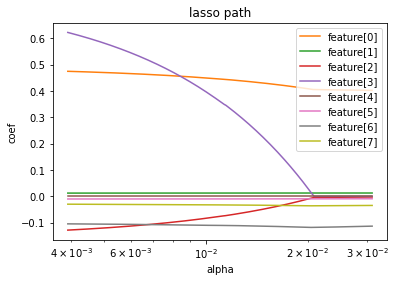

In [7]:
alphas = np.power(2, np.arange(-8, -5, 0.01))
alphas, coefs, _ = lasso_path(caX_train, cay_train, alphas=alphas, max_iter=1e5)
colors = ["C{}".format(str(i)) for i in range(1, coefs.shape[0] + 1)]

plt.figure(1)
ax = plt.gca()

for i in range(len(colors)):
    ax.plot(alphas, coefs[i], c=colors[i], label='feature[{}]'.format(str(i)))

ax.set_xscale("log")
ax.set_xlabel('alpha')
ax.set_ylabel('coef')
ax.set_title('lasso path')
ax.legend()
plt.show()

## Elastic Net

介绍完岭回归和Lasso, Elastic Net就不必多加赘述, 实际上它的损失函数是 $L_1$ 损失和 $L_2$ 损失的加权. 使用`ElasticNet`类创建实例, 分别用`alpha`和`l1_ratio`参数控制 $\alpha$ 和 $\rho$ 的大小, 再拟合数据, 就得到了Elastic Net模型. 对最优超参数的选择, 依然可以使用`ElasticNetCV`进行网格化搜索.

由于Elastic Net的损失函数中也包含 $L_1$ 正则, 因此可以用于特征筛选, 类似地`enet_path()`函数也提供了类似于`lasso_path()`的功能, 绘制模型系数随正则化参数变化的图, 不过在这一过程中, `l1_ratio`是不变的.